# Extract secondary structure from PDB files easily and generate spreadsheet

<a rel="license" href="https://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://licensebuttons.net/l/by-sa/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

Author: Dr Antonia Mey   
Email: antonia.mey@ed.ac.uk

In [1]:
# Imports
import pandas as pd
import numpy as np
import glob 
import os
import urllib
from collections import Counter
import urllib
import json
import matplotlib.pylab as plt

In [2]:
def get_domainn_region_info(data):
    known_things = {}
    known_things['Domain'] = []
    known_things['Region'] = []
    known_things['Motif'] = []
    #known_things['Helix'] = []
    if 'features' in data.keys():
        for d in data['features']:
            #print(d['type'])
            if d['type'] == 'Domain':
                known_things['Domain'].append([d['location']['start']['value'], d['location']['end']['value'], d['description']])            
    return known_things       

In [3]:
def feature_in_domain(domain_mask, start, end, percent_overlap=50):
    second_bool_array = np.zeros(len(domain_mask), dtype=bool)
    second_bool_array[start:end] = True
    overlap = (np.sum(np.logical_and(domain_mask, second_bool_array)))
    if overlap/(end-start)*100>=percent_overlap:
        return True
    else:
        return False 
    

In [4]:
def get_domain_mask(domain_dic, sequence_length):
    bool_array =  np.zeros(sequence_length, dtype=bool)
    for key in domain_dic.keys():
        for entry in known_things[key]:
            # print(f'checking entry {entry}')
    
            if entry[0] is None:
                continue
            elif entry[1] is None:
                continue
            bool_array[entry[0]-1:entry[1]] = True
    return bool_array

In [5]:
def get_domain_name(start, end, domain_dic):
    for d in domain_dic['Domain']:
        if (max(0, min(d[1], end) - max(d[0], start)))>0:
            return d[2]

## Testing things out

In [21]:
f = open('data_idr/expressed_uni_prot_ids.txt', 'r')
f_content = f.readlines()
f.close()

In [22]:
ids = []
for f in f_content:
    ids.append(f.strip())

In [23]:
fail_list = []
verbose = False

In [241]:
# Process uniprot file
f = open('unique_ids/Q8TAD8.json')
data = json.load(f)
f.close()

# print('read json file successfully')

# Some basics:
# checking keys
keys = data.keys()

# Primary Accession
uni_id = 'NA'
if 'primaryAccession' in keys:
    uni_id = data['primaryAccession'] 
    if verbose:
         print('uni_id',uni_id)
else: 
    print('Issue: No primary Accession found')

# Genes
gene_name = 'NA'
if 'genes' in keys:
    gene_name = data['genes'][0]['geneName']['value']
    if verbose:
        print('gene_name',gene_name)
else:
    print('Issue: No gene found found')

In [246]:
data['features']

[{'type': 'Chain',
  'location': {'start': {'value': 1, 'modifier': 'EXACT'},
   'end': {'value': 396, 'modifier': 'EXACT'}},
  'description': 'Smad nuclear-interacting protein 1',
  'featureId': 'PRO_0000072009'},
 {'type': 'Domain',
  'location': {'start': {'value': 281, 'modifier': 'EXACT'},
   'end': {'value': 344, 'modifier': 'EXACT'}},
  'description': 'FHA',
  'evidences': [{'evidenceCode': 'ECO:0000255',
    'source': 'PROSITE-ProRule',
    'id': 'PRU00086'}]},
 {'type': 'Region',
  'location': {'start': {'value': 1, 'modifier': 'EXACT'},
   'end': {'value': 227, 'modifier': 'EXACT'}},
  'description': 'Disordered',
  'evidences': [{'evidenceCode': 'ECO:0000256',
    'source': 'SAM',
    'id': 'MobiDB-lite'}]},
 {'type': 'Region',
  'location': {'start': {'value': 373, 'modifier': 'EXACT'},
   'end': {'value': 396, 'modifier': 'EXACT'}},
  'description': 'Disordered',
  'evidences': [{'evidenceCode': 'ECO:0000256',
    'source': 'SAM',
    'id': 'MobiDB-lite'}]},
 {'type': 'Coi

In [33]:
desired_features = ['Beta strand','Helix','Turn']

# get domain inforamtion
known_things = {}
final_table_list = []    
#ids = ['Q8TAD8']            
            
# loop over all uniprot ids
for i in range(len(ids)):
#for i in range(20):
    # Process uniprot file
    fname = 'unique_ids/'+ids[i]+'.json'


    if os.path.isfile(fname):
        f = open(fname)
        data = json.load(f)
        f.close()

        known_things = get_domainn_region_info(data)
        #print(known_things)
        
        keys = data.keys()

        sequence_length = data['sequence']['length']

        # populate dictionary:
        #print(f"sequence length is: {sequence_length}")
        gene_name = 'NA'
        if 'genes' in keys:
            gene_name = data['genes'][0]['geneName']['value']
            
        #print(f"gene name: {gene_name}")
        
        uni_id = 'NA'
        if 'primaryAccession' in keys:
            uni_id = data['primaryAccession'] 
        #print('uni_id',uni_id)
    

        if 'features' in keys:
            
            # populate domain information
            for d in data['features']:
                #print(d['type'])
                if d['type'] == 'Domain':
                    known_things['Domain'].append([d['location']['start']['value'], d['location']['end']['value'], d['description']])
            
            domain_mask = get_domain_mask(known_things,sequence_length)

            #if len(final_table_list)>0:
            #    final_table_list[-1]['gap'] = final_table_list[-1]['sequence length']-final_table_list[-1]['end']
            
            # now check secondary structure features and if there is overlap
            starts = []
            ends = []
            count = 0
            gap = None
            for f in data['features']:
                if f['type'] in desired_features:
                    final_table_dic = {}
                    # print('=====New feature====')
                    # print(f['type'])

                    start = f['location']['start']['value']
                    end = f['location']['end']['value']

                    # Check if features is in domain
                    if feature_in_domain(domain_mask, start, end, percent_overlap=50):
                        domain_feature_overalp = 'Yes'
                        domain_name = get_domain_name(start,end,known_things)
                    else:
                        domain_feature_overalp = 'No'  
                        domain_name = 'None'
                    

                    if len(ends)>0:
                        gap = start-ends[-1]
                    #elif count == len(data['features'])-1:
                    #    print('this happens')
                    #    gap = (sequence_length-end)
                    #else:
                    #    gap = start
                    feature_length = end - start
                    final_table_dic['gene name'] = gene_name
                    final_table_dic['Uniprot ID'] = uni_id
                    final_table_dic['sequence length'] = sequence_length
                    final_table_dic['Feature name'] = f['type']
                    final_table_dic['start'] = start
                    final_table_dic['end'] = end
                    final_table_dic['length'] = feature_length
                    if gap is None:
                        final_table_dic['gap left'] = gap
                    else:
                        final_table_dic['gap left'] = int(gap)
                    final_table_dic['Overlap with domain'] = domain_feature_overalp
                    final_table_dic['Domain name'] = domain_name
                    if verbose: 
                        print(f"start: {start}")
                        print(f"end: {end}")
                        print(f"length: {feature_length}")
                        print(f"gap: {gap}")
                        print(f"Domain feature overlap: {domain_feature_overalp}")
                        print(f"domain name: {domain_name}")
                    starts.append(start)
                    ends.append(end)
                    final_table_list.append(final_table_dic)
                    count+=1
            starts = np.array(starts)
            ends = np.array(ends)
            gaps = (starts[1:-1]-ends[0:-2])-1



In [34]:
df = pd.DataFrame(final_table_list)  

In [35]:
df

,gene name,Uniprot ID,sequence length,Feature name,start,end,length,gap left,Overlap with domain,Domain name
0,E2F8,A0AVK6,867,Helix,114,116,2,NaN,No,None
1,E2F8,A0AVK6,867,Helix,118,128,10,2.0,No,None
2,E2F8,A0AVK6,867,Beta strand,135,137,2,7.0,No,None
3,E2F8,A0AVK6,867,Helix,142,148,6,5.0,No,None
4,E2F8,A0AVK6,867,Helix,154,166,12,6.0,No,None
...,...,...,...,...,...,...,...,...,...,...
92489,CAMTA1,Q9Y6Y1,1673,Beta strand,909,912,3,3.0,Yes,IPT/TIG
92490,CAMTA1,Q9Y6Y1,1673,Beta strand,914,917,3,2.0,Yes,IPT/TIG
92491,CAMTA1,Q9Y6Y1,1673,Beta strand,920,924,4,3.0,Yes,IPT/TIG
92492,CAMTA1,Q9Y6Y1,1673,Beta strand,930,939,9,6.0,Yes,IPT/TIG


In [36]:
df.to_csv('trial_table.csv', index=False)

<Axes: xlabel='gap', ylabel='Count'>

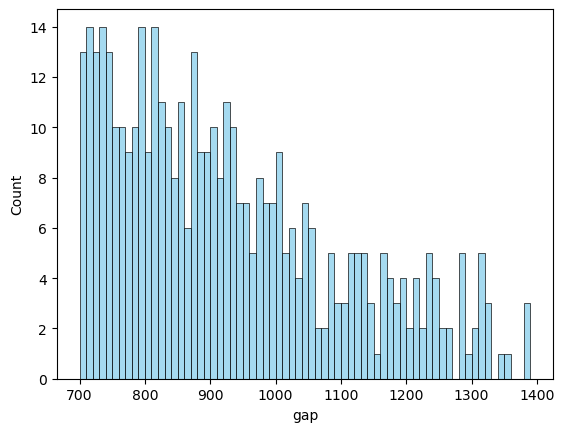

In [240]:
import seaborn as sbn
sbn.histplot(df['gap'], bins=np.arange(700, 1400, 10), kde=False, color='skyblue')
#plt.yscale('log')

### Getting list of uniprot IDS that are expressed in cells

In [181]:
df = pd.read_csv('filtered_table_final_100223.csv')

In [183]:
selected_rows = df[df['HEK293T_expressed'] == 1]

In [190]:
ids_to_be_used = selected_rows['uniprot_id'].values
ids_to_be_used = np.unique(ids_to_be_used)
f = open('data_idr/expressed_uni_prot_ids.txt','w')
for uni in ids_to_be_used:
    f.write(uni+'\n')
f.close()